In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import copy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.9.0+cu102


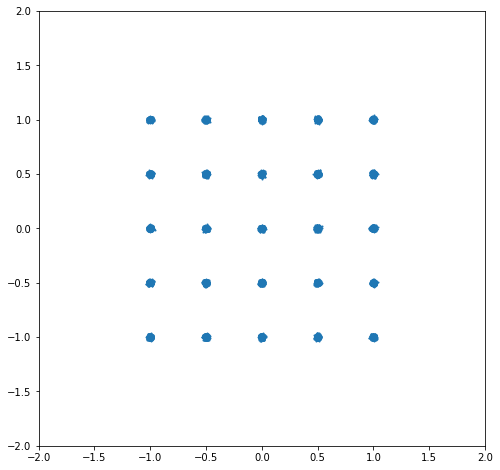

In [13]:
class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self):

        num_data = 50000
        num_class = 25

        y = [[i] * (num_data //num_class) for i in range(num_class)]
        y = np.array(y, dtype=np.int64).reshape(-1)
        x = np.random.randn(num_data, 2) * 0.01
        for i in range(num_data):
            x[i] += [-1 + (2 / 4) * (y[i] // 5), -1 + (2 / 4) * (y[i] % 5)]
        y = np.array(y, dtype=np.int64)

        self.x = x
        self.y = y


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



dataset = CustomDataSet()

plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.scatter(dataset.x[:, 0], dataset.x[:, 1], s=1)
plt.show()


In [14]:
class Jem(nn.Module):
    def __init__(self, num_classes=25):
        super().__init__()
        self.net1 = nn.Linear(2, 32)
        self.net2 = nn.Linear(32, 32)
        self.net3 = nn.Linear(32, 32)
        self.net4 = nn.Linear(32, 32)
        self.net5 = nn.Linear(32, 32)
        self.net6 = nn.Linear(32, 32)
        self.net7 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.net1(x)
        x = x.sigmoid() * x
        x = x + self.net2(x)
        x = x.sigmoid() * x
        x = x + self.net3(x)
        x = x.sigmoid() * x
        x = x + self.net4(x)
        x = x.sigmoid() * x

        x = x + self.net5(x)
        x = x.sigmoid() * x
        x = x + self.net6(x)
        x = x.sigmoid() * x
        joint_energy = self.net7(x)
        unnorm_prob = (-joint_energy).exp()
        partition = unnorm_prob.sum(dim=-1, keepdim=True)
        prob = unnorm_prob / partition
        x_energy = -(partition + 1e-5).log()
        return prob, x_energy
    


In [15]:
class ChainBuffer(object):
    def __init__(self, size, shape):
        self.size = size
        self.shape = shape
        self.queue = deque(maxlen=self.size)

    def __len__(self):
        return len(self.queue)

    def push(self, imgs):
        for img in imgs:
            self.queue.append(img)

    def get(self, batch_size):
        return [np.stack(x) for x in random.sample(self.queue, batch_size)]

    def sample(self, batch_size, init_prob=0.05):

        num_gets = 0
        if len(self) > 0:
            num_gets = np.random.binomial(min(len(self), batch_size), 1. - init_prob)
    
        data, is_init = None, []

        if num_gets > 0:
            data = np.array(self.get(num_gets))
            is_init += [False for _ in range(num_gets)]

        if batch_size > num_gets:
            shape = (batch_size - num_gets, *self.shape)
            if data is None:
                data = 2. * np.random.rand(*shape) - 1.
            else:
                data = np.concatenate([data, 2. * np.random.rand(*shape) - 1.], axis=0)
            is_init += [True for _ in range(batch_size - num_gets)]
        
        return data, np.array(is_init, dtype=np.bool)



In [18]:
batch_size = 64
lr = 1e-4
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
jem = Jem()
optimizer = optim.Adam(jem.parameters(), lr=lr)
buffer = ChainBuffer(50000, shape=(2, ))

In [19]:
def langevin_dynamics(x, net, num_steps, step_size):
    for i in range(num_steps):
        net.zero_grad()
        x = x.requires_grad_(True)
        _, energy = net(x)
        energy.mean().backward()
        x.data -= 0.5 * step_size * step_size * x.grad
        x.data += step_size * torch.randn_like(x)
        x = x.clone().detach()
    return x

In [20]:
for epoch in range(50):
    avg_loss = np.array([0., 0., 0.])

    for x, y in loader:
        x = x.float().to(device)

        optimizer.zero_grad()
        x_neg, is_init = buffer.sample(batch_size)
        x_neg = torch.FloatTensor(x_neg).to(device)

        x_neg = langevin_dynamics(x_neg, jem, 100, 0.001)
        buffer.push(x_neg.detach().cpu().numpy())


        _, neg_e = jem(x_neg)
        prob, pos_e = jem(x)


        ce_loss = -(F.one_hot(y, 25) * (prob + 1e-7).log()).sum(dim=-1).mean()

        pos_e = pos_e.mean()
        neg_e = neg_e.mean()
        l2_loss = pos_e.pow(2) + neg_e.pow(2)

        contrastive_loss = pos_e - neg_e + 0.1 * l2_loss



        loss = ce_loss + contrastive_loss
        loss.backward()

        optimizer.step()

        avg_loss += [pos_e.item(), neg_e.item(), ce_loss.item()]

    avg_loss /= len(loader)
    print(avg_loss)

[-3.31806654 -2.99603542  2.23167738]
[-4.17098245 -0.9066803   0.21313276]
[-4.7036124  -0.31133     0.03418042]
[-4.77046604 -0.22899012  0.01664485]
[-4.8038132  -0.19920669  0.01068176]
[-4.837165  -0.1637145  0.0073216]
[-4.8534087  -0.14556883  0.00589479]
[-4.86397243e+00 -1.33627321e-01  4.44074832e-03]
[-4.87754572e+00 -1.22683557e-01  3.77449483e-03]
[-4.88929083e+00 -1.10433195e-01  2.98272103e-03]
[-4.90422962e+00 -9.48885688e-02  2.76209416e-03]
[-4.91887074e+00 -7.91532559e-02  2.41248144e-03]
[-4.91926286e+00 -8.20382922e-02  2.14163196e-03]
[-4.92749093e+00 -7.48467660e-02  1.87505682e-03]
[-4.92192315e+00 -7.41646592e-02  1.71085891e-03]
[-4.94093331e+00 -6.48226998e-02  1.51606578e-03]
[-4.93471297e+00 -5.89921780e-02  1.48501169e-03]
[-4.93995509e+00 -6.36738860e-02  1.37530494e-03]
[-4.94230923e+00 -5.59446005e-02  1.36244869e-03]
[-4.94603448e+00 -5.24135725e-02  1.24554028e-03]
[-4.95388255e+00 -5.03014740e-02  1.10789194e-03]
[-4.95397976e+00 -4.26247065e-02  1.2

KeyboardInterrupt: ignored

In [24]:
sample = list(buffer.queue)
sample = np.array(sample)
sample = torch.Tensor(sample)
sample = langevin_dynamics(sample, jem, 2000, 0.0001)

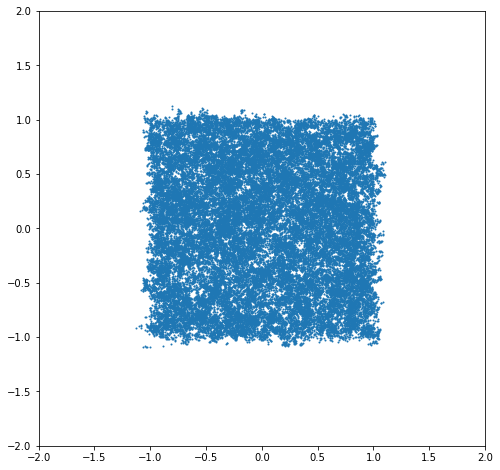

In [26]:
plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
sample = sample.numpy()
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.show()